## One station models
LSTM_tensorflow_tutorial [link](https://www.tensorflow.org/tutorials/structured_data/time_series)

In [27]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import r2_score, mean_absolute_error
import math
from scipy import stats
import json

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
%matplotlib inline

In [28]:
### Set fixed variables
input_path = 'data/PROCESSED/STATIONS_CLEAN'
path = 'data/PROCESSED/MODEL_OUTPUTS'

## sampling frequency
sample_freq = 60 #(time in minutes)
steps=int(sample_freq/5)
time_steps = int(60/sample_freq)
#60min - 12 steps
#30min - 6 steps
#15min - 3 steps
#5min - 1 step

MAX_EPOCHS = 20

#station
station = 'pisayambo'

In [29]:
files_ids = {'guadalupe':'guadalupe_validation.csv',
         'banos':'banos_validation.csv',
         'aeropuerto': 'aeropuerto_validation.csv',
         'quisapincha':'quisapincha_validation.csv',
         'chiquiurco':'chiquiurco_validation.csv',
         'AJSucre':'AJSucre_validation.csv',
         'JAlvarez':'JAlvarez_validation.csv',
         'pfc-hgpt':'pfc-hgpt_validation.csv',
         'calamaca':'calamaca_validation.csv',
         'mulaCorral':'mulaCorral_validation.csv',
         'pampasSalasaca':'pampasSalasaca_validation.csv',
         'tasinteo':'tasinteo_validation.csv',
         'pisayambo':'pisayambo_validation.csv'
         }

In [30]:
df = pd.read_csv(f'{input_path}/{station}_validation.csv')

In [31]:
df.head()

,Date_Time,ATAvg,ATMax,ATMin,RHAvg,RHMin,RHMax,PAvg,WDAvg,WSAvg,WAvgx,WAvgy,WMaxx,WMaxy,WMinx,WMiny,Day_sin,Day_cos,Year_sin,Year_cos
0,2013-05-08 14:20:00,9.73,9.73,9.73,89.73,89.73,89.73,0.1,130.915,4.48,-2.934125,3.385456,-3.491434,2.807185,-2.227800,3.886812,-0.573576,-0.819152,0.805618,-0.592436
1,2013-05-08 14:25:00,10.04,10.33,9.71,89.83,88.77,91.36,0.0,130.915,4.81,-3.150255,3.634831,-4.036971,3.245808,-2.118399,3.695942,-0.591310,-0.806445,0.805582,-0.592484
2,2013-05-08 14:30:00,10.63,10.89,10.44,88.50,88.25,88.77,0.0,130.915,4.61,-3.019267,3.483694,-3.826549,3.076625,-2.093535,3.652562,-0.608761,-0.793353,0.805547,-0.592532
3,2013-05-08 14:35:00,11.19,11.45,10.87,88.24,86.16,89.40,0.0,130.915,3.77,-2.469119,2.848921,-3.507021,2.819717,-1.710632,2.984516,-0.625923,-0.779884,0.805512,-0.592580
4,2013-05-08 14:40:00,11.49,11.68,11.31,87.01,86.36,88.34,0.0,130.915,4.10,-2.685249,3.098296,-3.771996,3.032762,-1.601231,2.793646,-0.642788,-0.766044,0.805476,-0.592628


In [32]:
#### The data has already been cleaned, wind transformed to vector and added perodicity
### Check for NAN values and delete before running models
df.isna().sum()
df.isnull().values.any()

False

In [33]:
### Subsample to get data for every hour (starting from index 0, get 12 steps)
df = df[0::steps]

In [34]:
df.head()

,Date_Time,ATAvg,ATMax,ATMin,RHAvg,RHMin,RHMax,PAvg,WDAvg,WSAvg,WAvgx,WAvgy,WMaxx,WMaxy,WMinx,WMiny,Day_sin,Day_cos,Year_sin,Year_cos
0,2013-05-08 14:20:00,9.73,9.73,9.73,89.73,89.73,89.73,0.1,130.915,4.48,-2.934125,3.385456,-3.491434,2.807185,-2.227800,3.886812,-0.573576,-0.819152,0.805618,-0.592436
12,2013-05-08 15:20:00,10.60,10.77,10.48,83.18,81.61,84.45,0.0,132.520,5.03,-3.399513,3.707319,-4.302853,3.295733,-2.171285,3.406923,-0.766044,-0.642788,0.805193,-0.593013
24,2013-05-08 16:20:00,12.34,12.68,12.14,69.73,68.67,70.51,0.0,135.780,4.74,-3.397003,3.305749,-4.549909,3.383375,-2.291088,3.193089,-0.906308,-0.422618,0.804768,-0.593590
36,2013-05-08 17:20:00,10.84,11.18,10.38,75.02,73.66,75.97,0.0,136.740,3.54,-2.578010,2.425998,-3.354063,2.610127,-1.786614,2.422419,-0.984808,-0.173648,0.804342,-0.594167
48,2013-05-08 18:20:00,8.60,8.64,8.55,86.65,86.26,87.24,0.0,131.365,3.08,-2.035429,2.311586,-2.873263,2.456168,-1.307034,2.107620,-0.996195,0.087156,0.803916,-0.594743


In [35]:
date_time = pd.to_datetime(df.pop('Date_Time'), format='%Y-%m-%d %H:%M:%S')

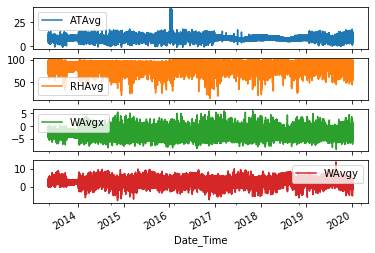

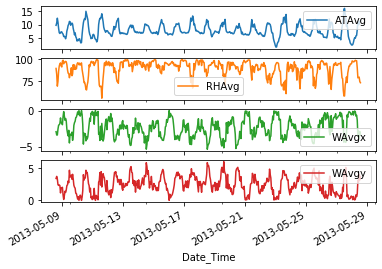

In [36]:
plot_cols = ['ATAvg', 'RHAvg', 'WAvgx','WAvgy']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [37]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ATAvg,58462.0,7.516787,2.384837,-1.130000,6.050000,6.940000,8.890000,38.880000
ATMax,58462.0,7.658274,2.389683,-0.940000,6.090000,7.010000,9.070000,39.800000
ATMin,58462.0,7.479469,2.283638,-1.480000,6.020000,6.910000,8.890000,39.810000
RHAvg,58462.0,88.322523,10.084724,14.070000,84.625000,91.630000,95.070000,100.160000
RHMin,58462.0,88.098029,9.666399,15.020000,83.535000,91.560000,94.610000,100.160000
RHMax,58462.0,89.573024,8.726569,16.570000,85.760000,92.680000,95.300000,100.170000
PAvg,58462.0,0.013068,0.054179,0.000000,0.000000,0.000000,0.000000,2.900000
WDAvg,58462.0,143.078971,52.862820,2.540000,121.430000,134.690000,145.410000,350.980000
WSAvg,58462.0,3.698443,1.980458,0.000000,2.130000,3.720000,5.200000,14.800000
WAvgx,58462.0,-2.208184,1.807715,-9.109023,-3.446739,-2.303162,-1.000169,5.952118


In [38]:
### Remove PAvg and WMaxx, WMiny, WDAvg and WSAvg
df = df[['ATAvg','ATMax','ATMin',
         'RHAvg','RHMin','RHMax',
         'WAvgx','WAvgy', 'WMinx', 'WMiny',
         'Day_sin', 'Day_cos', 'Year_sin', 'Year_cos']]

In [39]:
### Split data into 70%, 20%, 10% split for the training, validation, and test sets
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [40]:
### Normalize the data  ### ROOM TO MAKE TESTS (this is just an average)
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

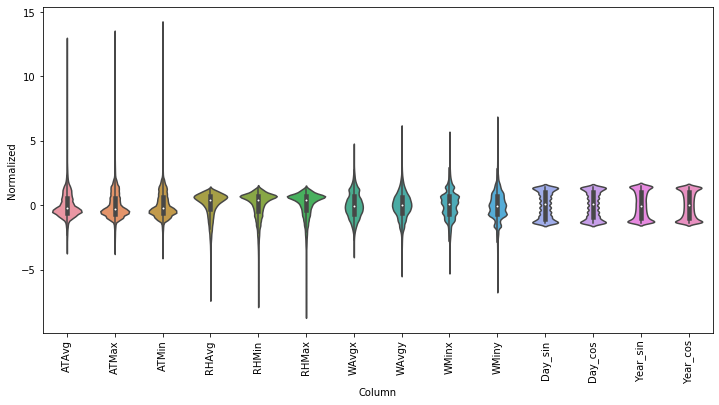

In [41]:
## Feature distributions
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [42]:
%run model_utils.ipynb

## MULTI-VARIATE + SINGLE STEP MODEL

- 24 hours prior --> predict 1 hour
- 24 hours prior --> predict 6 hours
- 48 hours prior --> predict 1 hours
- 48 hours prior --> predict 6 hours
- 48 hours prior --> predict 12 hours
- 48 hours prior --> predict 24 hours

## Windows

In [43]:
num_features = df.shape[1]

### 24 h + 1h

input_width = 24*time_steps
OUT_STEPS = 1*time_steps
performance = single_models(num_features=num_features,
                                                 station=station,
                                                 path=path,
                                                 input_width=input_width, 
                                                 OUT_STEPS = OUT_STEPS)

### 24 h + 6h

input_width = 24*time_steps
OUT_STEPS = 6*time_steps
performance = single_models(num_features=num_features,
                                                 station=station,
                                                 path=path,
                                                 input_width=input_width, 
                                                 OUT_STEPS = OUT_STEPS)

### 24 h + 24h

input_width = 24*time_steps
OUT_STEPS = 24*time_steps
performance = single_models(num_features=num_features,
                                                 station=station,
                                                 path=path,
                                                 input_width=input_width, 
                                                 OUT_STEPS = OUT_STEPS)

### 48 h + 6h

input_width = 48*time_steps
OUT_STEPS = 6*time_steps
performance = single_models(num_features=num_features,
                                                 station=station,
                                                 path=path,
                                                 input_width=input_width, 
                                                 OUT_STEPS = OUT_STEPS)

### 48 h + 12h

input_width = 48*time_steps
OUT_STEPS = 12*time_steps
performance = single_models(num_features=num_features,
                                                 station=station,
                                                 path=path,
                                                 input_width=input_width, 
                                                 OUT_STEPS = OUT_STEPS)

### 48 h + 24h

input_width = 48*time_steps
OUT_STEPS = 24*time_steps
performance = single_models(num_features=num_features,
                                                 station=station,
                                                 path=path,
                                                 input_width=input_width, 
                                                 OUT_STEPS = OUT_STEPS)

### 48 h + 48h

input_width = 48*time_steps
OUT_STEPS = 48*time_steps
performance = single_models(num_features=num_features,
                                                 station=station,
                                                 path=path,
                                                 input_width=input_width, 
                                                 OUT_STEPS = OUT_STEPS)

# MULTI-VARIATE + MULTI-STEP MODEL

## Windows
- 24 hours prior --> predict 1-12 hour
- 24 hours prior --> predict 1-24 hours
- 48 hours prior --> predict 1-12 hours
- 48 hours prior --> predict 1-24 hours
- 48 hours prior --> predict 1-36 hours
- 48 hours prior --> predict 1-48 hours
- 72 hours prior --> predict 1-24 hours
- 72 hours prior --> predict 1-48 hours

### 24 h + 12h

In [44]:
num_features = df.shape[1]
vars_to_analize = ['ATAvg','RHAvg']

365/365 [==============================] - 2s 5ms/step - loss: 0.2917 - mean_absolute_error: 0.3334


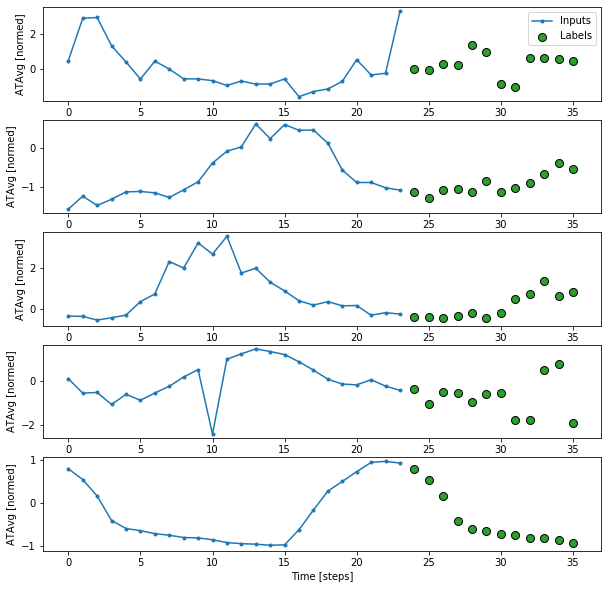

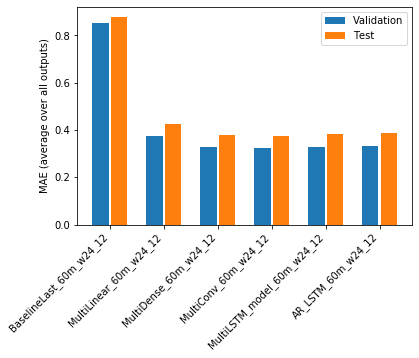

In [45]:
input_width = 24*time_steps
OUT_STEPS =12*time_steps
performance = multi_models(station, path, num_features,input_width, OUT_STEPS)

### 24 h + 24h

364/364 [==============================] - 3s 7ms/step - loss: 0.3230 - mean_absolute_error: 0.3509


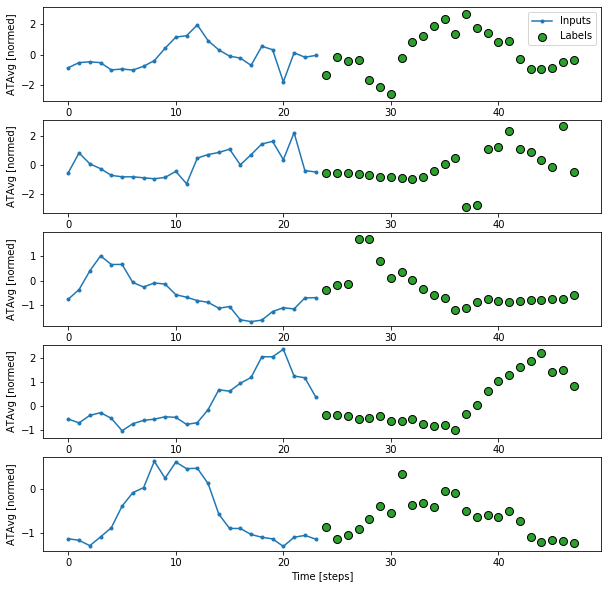

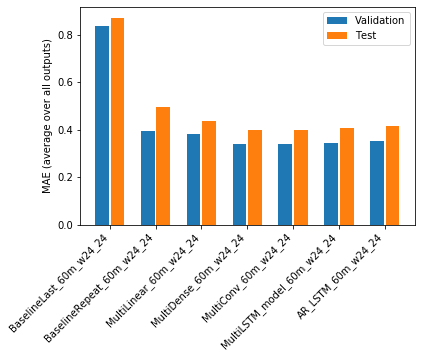

In [46]:
input_width = 24*time_steps
OUT_STEPS = 24*time_steps
performance = multi_models(station, path, num_features,input_width= input_width, OUT_STEPS=OUT_STEPS)

### 48 h + 12h

364/364 [==============================] - 3s 7ms/step - loss: 0.2942 - mean_absolute_error: 0.3354


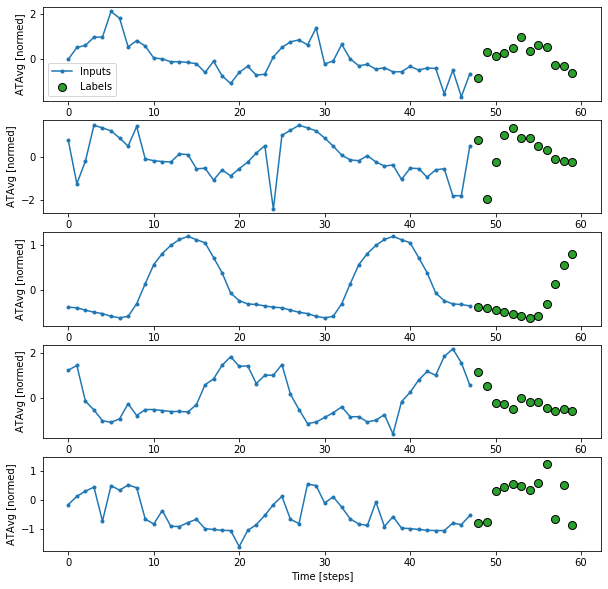

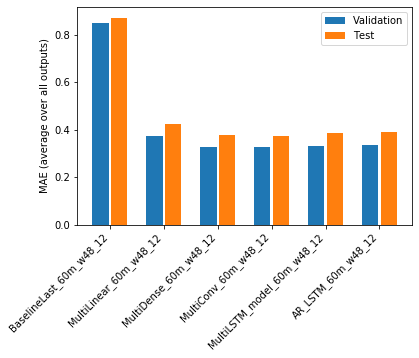

In [47]:
input_width = 48*time_steps
OUT_STEPS = 12*time_steps
performance = multi_models(station, path, num_features,input_width= input_width, OUT_STEPS=OUT_STEPS)

### 48 h + 24h

364/364 [==============================] - 3s 7ms/step - loss: 0.3262 - mean_absolute_error: 0.3548


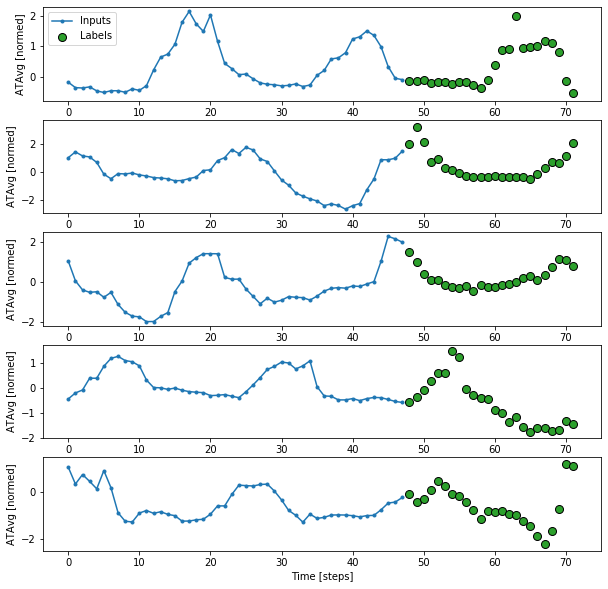

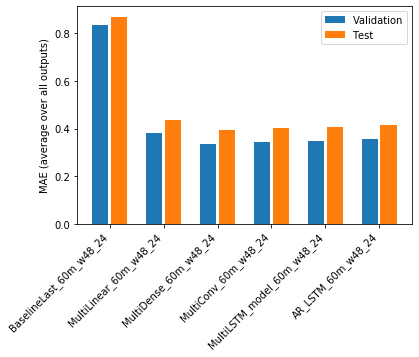

In [48]:
input_width = 48*time_steps
OUT_STEPS = 24*time_steps
performance = multi_models(station, path, num_features,input_width= input_width, OUT_STEPS=OUT_STEPS)

### 48 h + 48h

363/363 [==============================] - 3s 9ms/step - loss: 0.3603 - mean_absolute_error: 0.3704


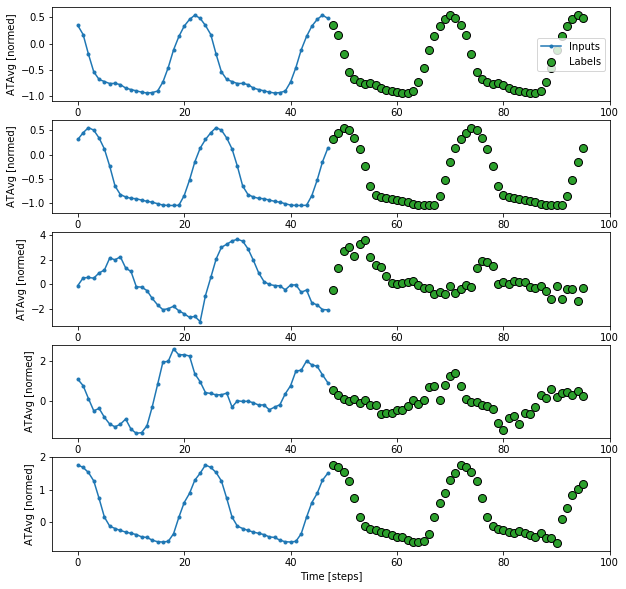

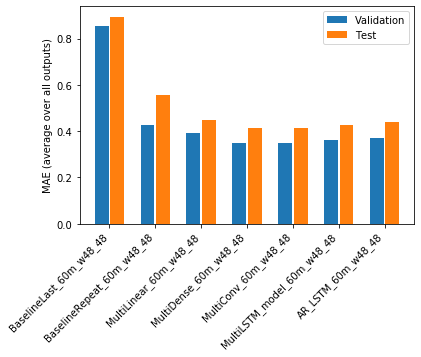

In [49]:
input_width = 48*time_steps
OUT_STEPS =48*time_steps
performance = multi_models(station, path, num_features,input_width= input_width, OUT_STEPS=OUT_STEPS)


### 72 h + 12h

363/363 [==============================] - 3s 9ms/step - loss: 0.2920 - mean_absolute_error: 0.3371


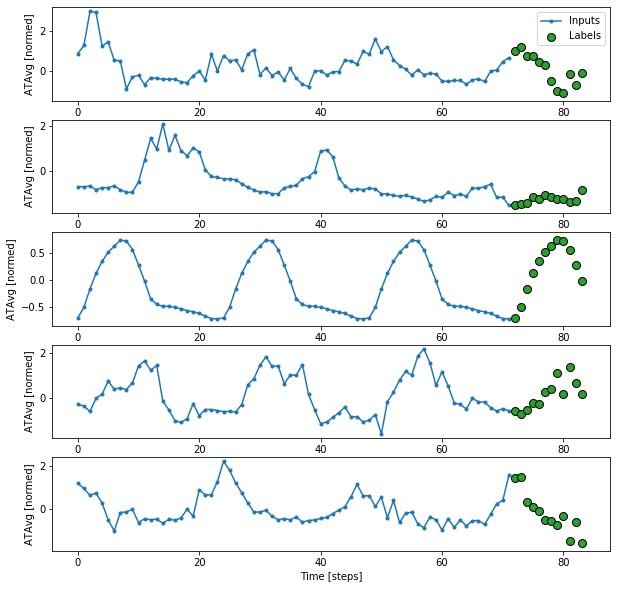

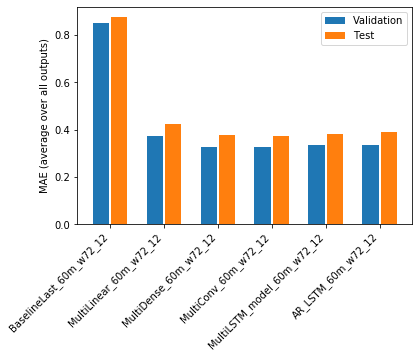

In [50]:
input_width = 72*time_steps
OUT_STEPS = 12*time_steps
performance = multi_models(station, path, num_features,input_width= input_width, OUT_STEPS=OUT_STEPS)

### 72 h + 24h

363/363 [==============================] - 4s 10ms/step - loss: 0.3239 - mean_absolute_error: 0.3488


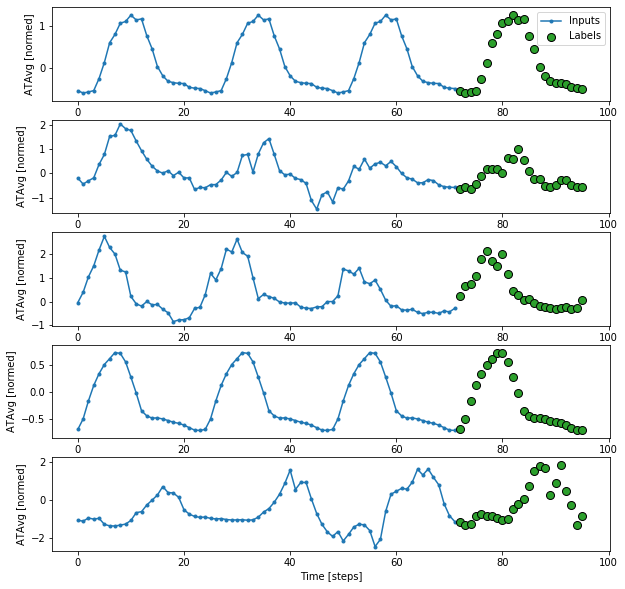

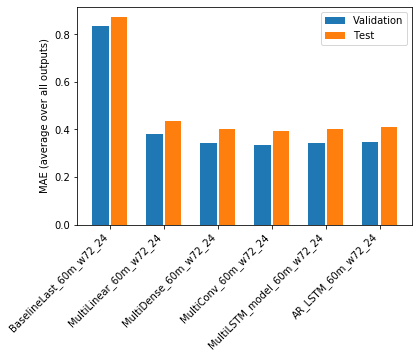

In [51]:
input_width = 72*time_steps
OUT_STEPS = 24*time_steps
performance = multi_models(station, path, num_features,input_width= input_width, OUT_STEPS=OUT_STEPS)

### 72 h + 48h

362/362 [==============================] - 4s 10ms/step - loss: 0.3584 - mean_absolute_error: 0.3700


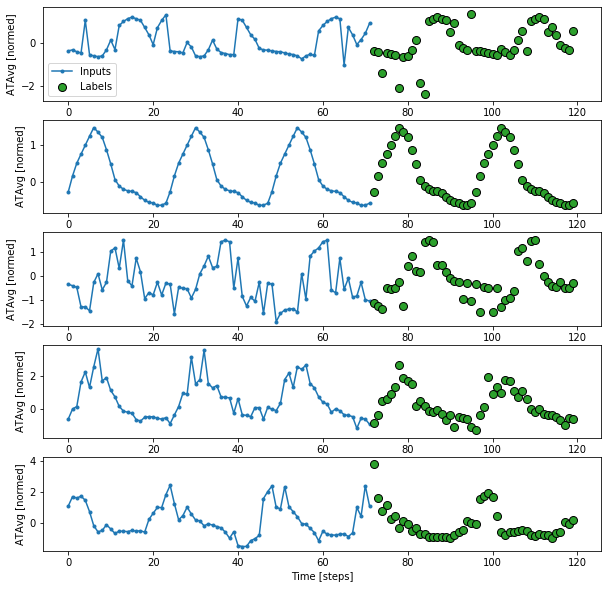

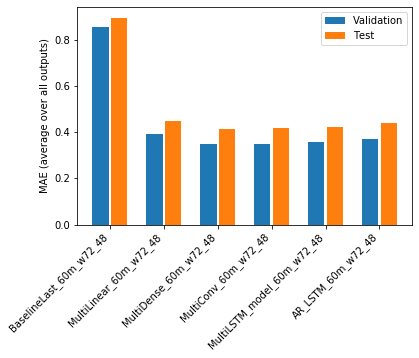

In [52]:
input_width = 72*time_steps
OUT_STEPS = 48*time_steps
performance = multi_models(station, path, num_features,input_width= input_width, OUT_STEPS=OUT_STEPS)